In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

### Gymnasium

https://gymnasium.farama.org

Это библиотека Python, которая предоставляет готовые реализации классических задач принятия решений — от управления роботами до видеоигр и настольных игр.

Вот как она работает:

In [2]:
# pip install gymnasium
# pip install pygame

In [3]:
import gymnasium as gym

In [4]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")

In [5]:
env.reset()

(array([-0.4738528,  0.       ], dtype=float32), {})

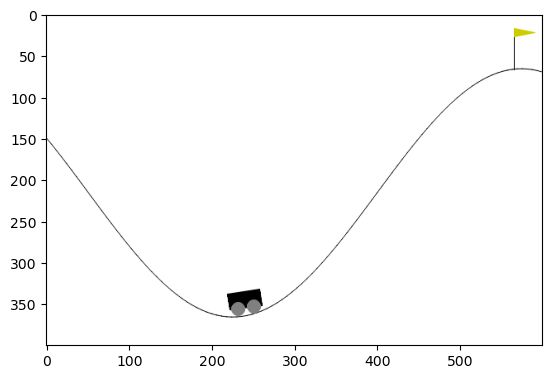

In [6]:
plt.imshow(env.render())
plt.show() 

https://gymnasium.farama.org/environments/classic_control/mountain_car/

Mountain Car
![Mountain Car](https://gymnasium.farama.org/_images/mountain_car.gif)

Это окружение является частью Classic Control, которое содержит общую информацию о среде.

Пространство действий
Discrete(3)

Пространство наблюдений
Box([-1.2 -0.07], [0.6 0.07], (2,), float32)

Описание
Mountain Car — это детерминированная среда MDP, в которой машина случайным образом размещается внизу синусоидальной долины. Единственные возможные действия — ускорения, применяемые к машине влево или вправо. Цель — стратегически ускоряться, чтобы достичь вершины правого холма. В Gymnasium есть две версии: с дискретными и непрерывными действиями. Здесь рассматривается версия с дискретными действиями.

Эта MDP впервые появилась в диссертации Эндрю Мура (1990):

### Пространство наблюдений
Наблюдение — это `ndarray` формы `(2,)`, где элементы соответствуют:  

| Индекс | Наблюдение               | Мин   | Макс  | Единицы измерения |
|--------|--------------------------|-------|-------|-------------------|
| 0      | Позиция машины по оси X  | -1.2  | 0.6   | м                 |
| 1      | Скорость машины          | -0.07 | 0.07  | м/с               |

### Пространство действий
Есть 3 дискретных действия:  
- `0`: Ускорение влево  
- `1`: Без ускорения  
- `2`: Ускорение вправо  



### Динамика переходов
Формулы обновления состояния:

```python
velocity_{t+1} = velocity_t + (action - 1) * force - cos(3 * position_t) * gravity
position_{t+1} = position_t + velocity_{t+1}
```

**Параметры:**  
- `velocity_t` - текущая скорость машины (диапазон: [-0.07, 0.07] м/с)  
- `action` - выбранное действие:  
  - `0`: ускорение влево  
  - `1`: без ускорения  
  - `2`: ускорение вправо  
- `force` - сила ускорения (константа: 0.001)  
- `position_t` - текущая позиция машины (диапазон: [-1.2, 0.6] м)  
- `gravity` - гравитационная постоянная (константа: 0.0025)  
- `cos(3*position_t)` - косинус угла наклона в текущей позиции (значения: [-1, 1])  

**Примечания:**  
1. Выражение `(action - 1)` преобразует действие в числовые значения:  
   - `-1` при ускорении влево  
   - `0` при отсутствии ускорения  
   - `+1` при ускорении вправо  
2. Косинусный член создает синусоидальный рельеф с периодом 2π/3  
3. Скорость и позиция автоматически ограничиваются указанными диапазонами  

### Физика среды
- **Столкновения**:  
  При ударе о стену скорость мгновенно обнуляется
- **Ограничения**:
  - Позиция: `[-1.2, 0.6]` (метры)
  - Скорость: `[-0.07, 0.07]` (м/с)

### Награда
- **Формула**: `-1` за каждый шаг
- **Цель**:  
  Минимизировать время достижения флага на вершине (правый холм)

### Инициализация
- **Стартовая позиция**:  
  Равномерно распределена в диапазоне `[-0.6, -0.4]`
- **Начальная скорость**:  
  Всегда `0.0` м/с

### Условия завершения
| Тип          | Условие                          | Лимит шагов |
|--------------|----------------------------------|-------------|
| **Terminated** | Позиция ≥ `0.5` (цель)          | -           |
| **Truncated**  | Достигнут максимум шагов (`200`) | 200         |

**Аргументы**

При создании среды (gymnasium.make) можно указать:

**render_mode**

**goal_velocity**

Пример:

```python
import gymnasium as gym
env = gym.make("MountainCar-v0", render_mode="rgb_array", goal_velocity=0.1)  # goal_velocity=0 по умолчанию
env.reset(seed=123, options={"x_init": np.pi/2, "y_init": 0.5})  # x_init=np.pi, y_init=1.0 по умолчанию

In [7]:
print("Observation space:", env.observation_space)

Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [8]:
print("Action space:", env.action_space)

Action space: Discrete(3)


Примечание: если вы запускаете это на локальном компьютере, появится окно с изображением выше. Не закрывайте его — просто переключитесь на другое окно (Alt+Tab).

### Интерфейс Gymnasium  
[Основы использования](https://gymnasium.farama.org/content/basic_usage/)  

Три основных метода среды:  

* `reset()`: Сбрасывает среду в начальное состояние и **_возвращает первое наблюдение_**  
* `render()`: Визуализирует текущее состояние среды (более красочная версия :) )  
* `step(a)`: Выполняет действие `a` и возвращает кортеж:  
  `(новое_наблюдение, награда, terminated, truncated, info)`  
  * `новое_наблюдение`: Состояние среды сразу после выполнения действия `a`  
  * `награда`: Число, представляющее награду за выполнение действия `a`  
  * `terminated`: `True`, если МПП завершился, `False` если продолжается  
  * `truncated`: `True`, если достигнут лимит шагов, `False` если продолжается  
  * `info`: Дополнительная информация (пока можно игнорировать)  



In [9]:
obs0 = env.reset()
print("начальное наблюдение (код):", obs0)

# Примечание: в MountainCar наблюдение — это всего два числа: позиция и скорость машины

начальное наблюдение (код): (array([-0.564012,  0.      ], dtype=float32), {})


In [10]:
print("выполняем действие 2 (вправо)")
new_obs, reward, terminated, truncated, _ = env.step(2)

print("новое наблюдение (код):", new_obs)
print("награда:", reward)
print("эпизод завершён?:", terminated)
print("превышено максимальное число шагов в эпизоде?:", truncated)

# Примечание: как видно, машина немного сдвинулась вправо (примерно на 0.0005)


выполняем действие 2 (вправо)
новое наблюдение (код): [-0.5627096   0.00130236]
награда: -1.0
эпизод завершён?: False
превышено максимальное число шагов в эпизоде?: False


### Поиграйтесь с этим

Ниже приведён код, который просто толкает машину вправо. Однако при использовании такой наивной стратегии машина не доберётся до флажка справа — ей будет мешать гравитация.

__Ваша задача__ — исправить это. Придумайте стратегию, которая позволит машине достичь флажка.

Пока не нужно строить какие-либо сложные алгоритмы, и уж точно не обязательно знать усиленное обучение. Можете просто захардкодить решение :)


In [11]:
from IPython import display

# Создаём окружение вручную, чтобы задать ограничение по времени. Пожалуйста, не изменяйте это.
TIME_LIMIT = 250
env = gym.wrappers.TimeLimit(
    gym.envs.classic_control.MountainCarEnv(),
    max_episode_steps=TIME_LIMIT + 1,
)
actions = {'left': 0, 'stop': 1, 'right': 2}


In [12]:
def policy(obs, t, start=-1, hist: list = None):
    position, velocity = obs
    # print(position, velocity)
    srt_pos =  -0.474639
    st = start
    course ={
        -1: "left",
        1: "right",
        0: "stop"
    }
    if not velocity:
        return actions[course[st]]
    eps = 0.0005
    if -velocity < -eps:
      st=1
    if velocity < eps:
      st=-1
    # print(st)
    return actions[course[st]]



In [13]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
plt.figure(figsize=(4, 3))
display.clear_output(wait=True)

obs = env.reset()
for t in range(TIME_LIMIT):
    time.sleep(0.3)
    plt.gca().clear()
    
    action = policy(obs, t)  # Вызываем вашу стратегию
    obs, reward, terminated, truncated, _ = env.step(action)  # Передаём выбранное действие в окружение
    
    # Здесь мы не используем награду, потому что в MountainCar она всегда -1.
    # Поэтому цель — как можно быстрее завершить эпизод.

    # Отображаем картинку из игры.
    plt.imshow(env.render());
    
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if terminated:
        print("Отлично, вы справились!")
        break
    if truncated:
        print("Время вышло. Попробуйте снова.")

display.clear_output(wait=True)


Отлично, вы справились!


In [14]:
assert obs[0] > 0.47
print("Задача решена!")

Задача решена!
